In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix
import xgboost as xgb

In [85]:
# Load the dataset
dataset = pd.read_csv('train (1).csv')

C:\Users\Admin\AppData\Local\Temp\ipykernel_20432\3852061944.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('train (1).csv')


In [86]:
# Drop columns with more than two-thirds NaN values
nan_threshold = 2/3 * len(dataset)
dataset = dataset.dropna(thresh=nan_threshold, axis=1)

# Fill NaN values for remaining columns
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)
    else:
        dataset[col].fillna(dataset[col].mean(), inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20432\4022479998.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[col].fillna(dataset[col].mode()[0], inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20432\4022479998.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

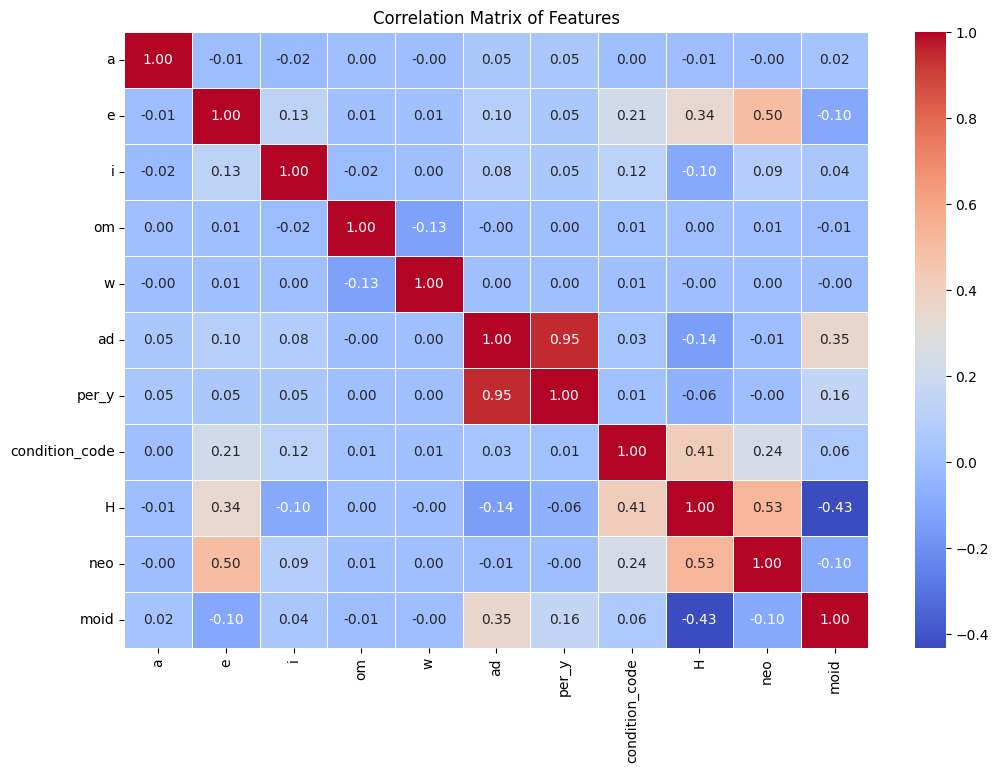

In [87]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

In [88]:
# Encode categorical variables
label_encoder = LabelEncoder()
dataset['neo'] = label_encoder.fit_transform(dataset['neo'])
dataset['pha'] = label_encoder.fit_transform(dataset['pha'])


In [89]:
# Separate features (X) and target variable (y)
X = dataset.drop(['pha', 'name', 'data_arc', 'q'], axis=1)
y = dataset['pha']

# Stratified split to ensure each category is represented in both training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [90]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [91]:
# Predict on the test set
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Training Set Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Set Accuracy: {test_accuracy * 100:.2f}%")

Training Set Accuracy: 100.00%
Test Set Accuracy: 99.97%


In [92]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[221734      5]
 [    62    483]]


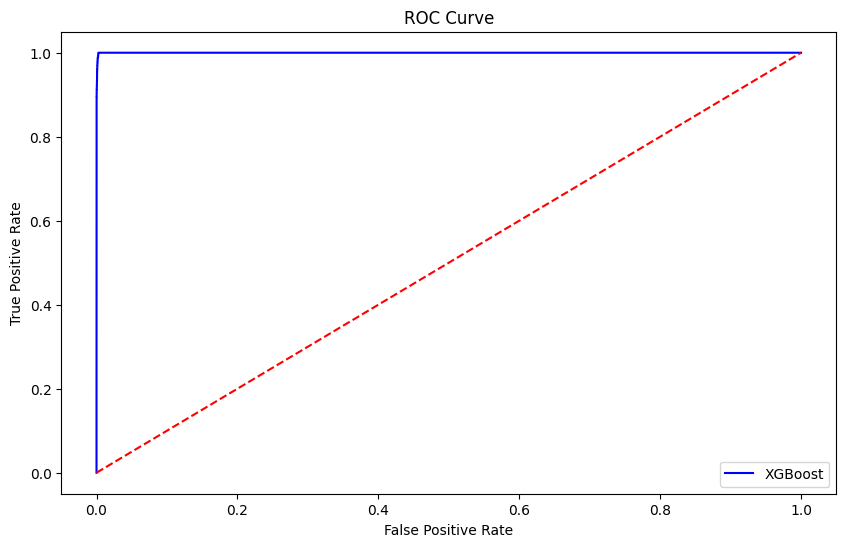

ROC-AUC Score: 1.00


In [93]:
# ROC curve
y_pred_proba_test = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='XGBoost')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"ROC-AUC Score: {roc_auc:.2f}")


In [94]:
# Cross-validation with accuracy scoring
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_accuracy = cross_val_score(xgb_model, X, y, cv=skf, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cross_val_accuracy.mean() * 100:.2f}%")

Cross-Validation Accuracy: 99.96%


In [95]:
# Save the model and preprocessing objects
import joblib
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Separate LabelEncoders for each categorical feature
label_encoder_neo = LabelEncoder()
label_encoder_pha = LabelEncoder()

# Fit and transform the 'neo' and 'pha' columns
dataset['neo'] = label_encoder_neo.fit_transform(dataset['neo'])
dataset['pha'] = label_encoder_pha.fit_transform(dataset['pha'])

# Save the LabelEncoders
joblib.dump(label_encoder_neo, 'label_encoder_neo.pkl')
joblib.dump(label_encoder_pha, 'label_encoder_pha.pkl')

['label_encoder_pha.pkl']

In [109]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

In [112]:
# Load the test dataset
test_dataset = pd.read_csv('test.csv')

# Encode categorical variables
#label_encoder = LabelEncoder()
#test_dataset['neo'] = label_encoder.fit_transform(test_dataset['neo'])

# Load the preprocessing objects
scaler = joblib.load('scaler.pkl')
label_encoder_neo = joblib.load('label_encoder_neo.pkl')






In [114]:
# Drop columns with more than two-thirds NaN values
nan_threshold = 2/3 * len(test_dataset)
test_dataset = test_dataset.dropna(thresh=nan_threshold, axis=1)

# Fill NaN values for remaining columns
for col in test_dataset.columns:
    if test_dataset[col].dtype == 'object':
       test_dataset[col].fillna(test_dataset[col].mode()[0], inplace=True)
    else :
        test_dataset[col].fillna(test_dataset[col].mean(), inplace=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_20432\2404352895.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_dataset[col].fillna(test_dataset[col].mode()[0], inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20432\2404352895.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [117]:
# Encode the 'neo' column using the label encoder fitted on training data
test_dataset['neo'] = label_encoder.transform(test_dataset['neo'])

# drop the same columns as in training
X_test_final = test_dataset.drop(['name', 'data_arc', 'q'], axis=1)

# Feature scaling using the scaler fitted on the training data
X_test_final = scaler.transform(X_test_final)

# Predict using the trained model
y_pred_test_final = xgb_model.predict(X_test_final)

In [122]:
# Add predictions to the test dataset
test_dataset['predicted_pha'] = y_pred_test_final_labels

# Save the predictions to a CSV file
test_dataset[['name', 'predicted_pha']].to_csv('test_predictions3.csv', index=False)

print("Predictions saved to test_predictions3.csv")


Predictions saved to test_predictions3.csv


In [123]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('test_predictions3.csv')

# Print the 'pha' column
print(df['predicted_pha'])

0        N
1        N
2        N
3        N
4        N
        ..
82323    N
82324    N
82325    N
82326    N
82327    N
Name: predicted_pha, Length: 82328, dtype: object
